# PapyrusNU Hieroglyph Detection - 02: Exploratory Data Analysis

This notebook provides a deep dive into the hieroglyph dataset, focusing on detailed analysis and visualization to inform our modeling strategy.

## Objectives:
1. Load the pre-processed and split data.
2. Perform advanced statistical analysis of annotations.
3. Create detailed visualizations for:
   - Bounding box characteristics (size, aspect ratio).
   - Spatial distribution of hieroglyphs on the papyrus.
   - Intricate class balance and relationships.
4. Generate insights to guide data augmentation and model configuration.

## Setup

In [1]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

'2.8.0+cu128'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15900, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 15900 (delta 69), reused 29 (delta 29), pack-reused 15787 (from 2)
Receiving objects: 100% (15900/15900), 6.45 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (11568/11568), done.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.3/477.3 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.8 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=3baff16856c4

In [3]:
import subprocess
import sys
import torch


# Check CUDA version to pick the correct Detectron2 wheel
cuda_version = torch.version.cuda
print(f"Detected CUDA version: {cuda_version}")

# Install other required packages that are not included with the detectron2 installation command
print("\nInstalling other required packages...")
other_packages = [
    'opencv-python-headless',
    'matplotlib>=3.3.0',
    'seaborn>=0.11.0',
    'plotly>=5.0.0',
    'pandas>=1.3.0',
    'scikit-learn>=1.0.0',
    'kaleido>=0.2.1',
    'pycocotools',
    'pillow>=8.0.0',
    'numpy',
    'tqdm',
    'ipywidgets'
]

try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + other_packages)
    print("✅ All other packages installed successfully!")
except subprocess.CalledProcessError as e:
    print(f"❌ Failed to install other packages: {e}")
except Exception as e:
    print(f"❌ Installation of other packages failed: {e}")

Detected CUDA version: 12.8

Installing other required packages...
✅ All other packages installed successfully!


In [10]:
# Import libraries
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import pandas as pd
from pathlib import Path
from google.colab import drive, files
import zipfile
import shutil
import plotly.express as px # Import plotly.express

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up paths
PROJECT_ROOT = '/content/drive/My Drive/PapyrusNU_Detectron'

# Set up paths
DATA_DIR = f'{PROJECT_ROOT}/data'
SCRIPTS_DIR = f'{PROJECT_ROOT}/scripts'
ANNOTATIONS_DIR = f'{DATA_DIR}/annotations'
ANALYSIS_PLOTS_DIR = f'{DATA_DIR}/analysis_plots'
os.makedirs(ANALYSIS_PLOTS_DIR, exist_ok=True)

# Add scripts to path
sys.path.append(SCRIPTS_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
import os

print("Current system path:")
for path in sys.path:
    print(path)

print("\nContents of scripts directory:")
scripts_dir = '/content/drive/My Drive/PapyrusNU_Detectron/scripts'
if os.path.exists(scripts_dir):
    for item in os.listdir(scripts_dir):
        print(item)
else:
    print(f"Directory not found: {scripts_dir}")

Current system path:
/content
/env/python
/usr/lib/python311.zip
/usr/lib/python3.11
/usr/lib/python3.11/lib-dynload

/usr/local/lib/python3.11/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.11/dist-packages/IPython/extensions
/root/.ipython
/tmp/tmpsntzgy_a
/content/drive/My Drive/PapyrusNU_Detectron/scripts

Contents of scripts directory:
visualization.py
evaluation.py
dataset_utils.py
__pycache__


In [6]:
# Import custom utilities
from dataset_utils import HieroglyphDatasetUtils
from visualization import HieroglyphVisualizer

print("Custom utilities imported successfully.")

Custom utilities imported successfully.


## Data Loading

We will load the full, unsplit dataset for a complete overview, as well as the training data split from the previous notebook.

In [7]:
# Load the full dataset annotations
full_annotation_file = f'{ANNOTATIONS_DIR}/annotations.json'
train_annotation_file = f'{ANNOTATIONS_DIR}/train_annotations.json'

if not os.path.exists(full_annotation_file):
    print("Error: Annotation files not found. Please run the data preparation notebook first.")
    # Placeholder for running in Colab
    # drive.mount('/content/drive')
    # !cp -r '/content/drive/My Drive/PapyrusNU_Detectron' '/content/'
else:
    dataset_utils = HieroglyphDatasetUtils(full_annotation_file)
    with open(train_annotation_file, 'r') as f:
        train_data = json.load(f)
    print("Datasets loaded successfully.")

Datasets loaded successfully.


## Annotation Analysis as DataFrame

For deeper analysis, we'll convert the annotations into a Pandas DataFrame.

In [8]:
# Convert annotations to a Pandas DataFrame
annotations_df = pd.DataFrame(dataset_utils.annotations)

# Enrich DataFrame with category names and bbox details
annotations_df['category_name'] = annotations_df['category_id'].apply(lambda x: dataset_utils.categories[x]['name'])
annotations_df['bbox_x'] = annotations_df['bbox'].apply(lambda x: x[0])
annotations_df['bbox_y'] = annotations_df['bbox'].apply(lambda x: x[1])
annotations_df['bbox_width'] = annotations_df['bbox'].apply(lambda x: x[2])
annotations_df['bbox_height'] = annotations_df['bbox'].apply(lambda x: x[3])
annotations_df['aspect_ratio'] = annotations_df['bbox_width'] / annotations_df['bbox_height']
annotations_df['bbox_center_x'] = annotations_df['bbox_x'] + annotations_df['bbox_width'] / 2
annotations_df['bbox_center_y'] = annotations_df['bbox_y'] + annotations_df['bbox_height'] / 2
annotations_df['area'] = annotations_df['bbox_width'] * annotations_df['bbox_height']

print("DataFrame created with annotation details:")
display(annotations_df.head())

DataFrame created with annotation details:


,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes,category_name,bbox_x,bbox_y,bbox_width,bbox_height,aspect_ratio,bbox_center_x,bbox_center_y
0,1,1,108,"[[1687.32, 2823.58, 1646.94, 2848.25, 1717.6, ...",4749.6826,"[1646.94, 2821.33, 132.34, 35.89]",0,"{'Unicode': 'U+13079', 'occluded': False}",D4,1646.94,2821.33,132.34,35.89,3.687378,1713.110,2839.275
1,2,1,353,"[[1654.79, 2874.05, 1760.22, 2869.56, 1761.34,...",2031.9085,"[1654.79, 2854.98, 106.55, 19.07]",0,"{'Unicode': 'U+13216', 'occluded': False}",N35,1654.79,2854.98,106.55,19.07,5.587310,1708.065,2864.515
2,3,1,13,"[[1685.07, 2940.22, 1653.67, 2925.64, 1689.56,...",9655.9872,"[1653.67, 2871.8, 113.28, 85.24]",0,"{'Unicode': '<g>A1B</g>', 'occluded': False}",A1B,1653.67,2871.80,113.28,85.24,1.328954,1710.310,2914.420
3,4,1,351,"[[1658.16, 2969.38, 1677.22, 2987.32, 1706.38,...",5439.1337,"[1653.67, 2949.19, 105.43, 51.59]",0,"{'Unicode': 'U+13210', 'occluded': False}",N31,1653.67,2949.19,105.43,51.59,2.043613,1706.385,2974.985
4,5,1,595,"[[1707.5, 3023.21, 1750.12, 3018.73, 1751.25, ...",1031.5557,"[1705.26, 3000.78, 45.99, 22.43]",0,"{'Unicode': 'U+133CF', 'occluded': False}",X1,1705.26,3000.78,45.99,22.43,2.050379,1728.255,3011.995


## Bounding Box Analysis

In [11]:
# Bounding Box Size vs. Aspect Ratio
fig = px.scatter(
    annotations_df,
    x='area',
    y='aspect_ratio',
    color='category_name',
    hover_data=['category_name', 'bbox_width', 'bbox_height'],
    log_x=True,
    log_y=True,
    title='Hieroglyph Size (Area) vs. Aspect Ratio (Log Scale)'
)
fig.update_layout(showlegend=False) # Hide legend to avoid clutter
fig.show()
fig.write_html(f'{ANALYSIS_PLOTS_DIR}/size_vs_aspect_ratio.html')

/usr/local/lib/python3.11/dist-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




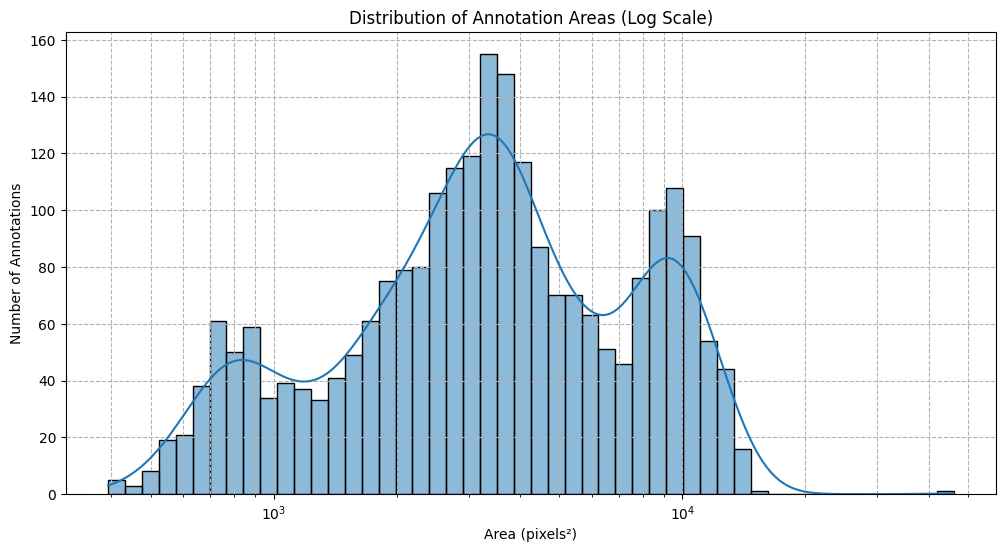

In [12]:
# Distribution of Annotation Sizes (Area)
plt.figure(figsize=(12, 6))
sns.histplot(data=annotations_df, x='area', bins=50, kde=True, log_scale=True)
plt.title('Distribution of Annotation Areas (Log Scale)')
plt.xlabel('Area (pixels²)')
plt.ylabel('Number of Annotations')
plt.grid(True, which="both", ls="--", c='0.7')
plt.savefig(f'{ANALYSIS_PLOTS_DIR}/area_distribution.png')
plt.show()

## Spatial Distribution Analysis

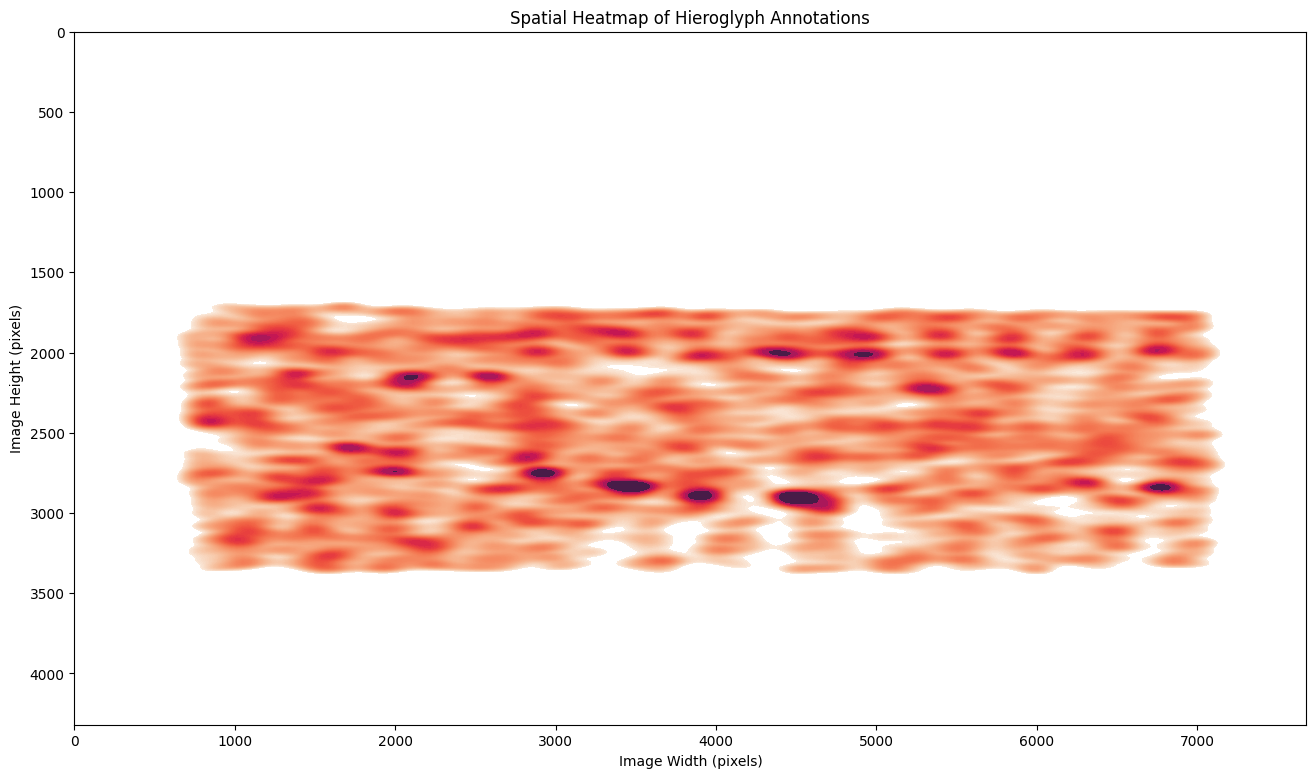

In [13]:
# Spatial Heatmap of Hieroglyph Locations
image_info = list(dataset_utils.images.values())[0]
img_width, img_height = image_info['width'], image_info['height']

plt.figure(figsize=(16, 9))
sns.kdeplot(data=annotations_df, x='bbox_center_x', y='bbox_center_y',
            fill=True, cmap="rocket_r", thresh=0.05, levels=100,
            bw_adjust=0.2)
plt.title('Spatial Heatmap of Hieroglyph Annotations')
plt.xlim(0, img_width)
plt.ylim(img_height, 0) # Invert y-axis to match image coordinates
plt.xlabel('Image Width (pixels)')
plt.ylabel('Image Height (pixels)')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f'{ANALYSIS_PLOTS_DIR}/spatial_heatmap.png')
plt.show()

This heatmap shows where hieroglyphs are concentrated on the papyrus. We see distinct columns of text, which is expected.

## Advanced Class Analysis

In [14]:
# Sunburst chart of class distribution
annotations_df['gardiner_series'] = annotations_df['category_name'].str[0] # e.g., 'A' from 'A1'

fig = px.sunburst(annotations_df, path=['gardiner_series', 'category_name'],
                  title='Interactive Sunburst of Hieroglyph Categories')
fig.show()
fig.write_html(f'{ANALYSIS_PLOTS_DIR}/class_sunburst_chart.html')

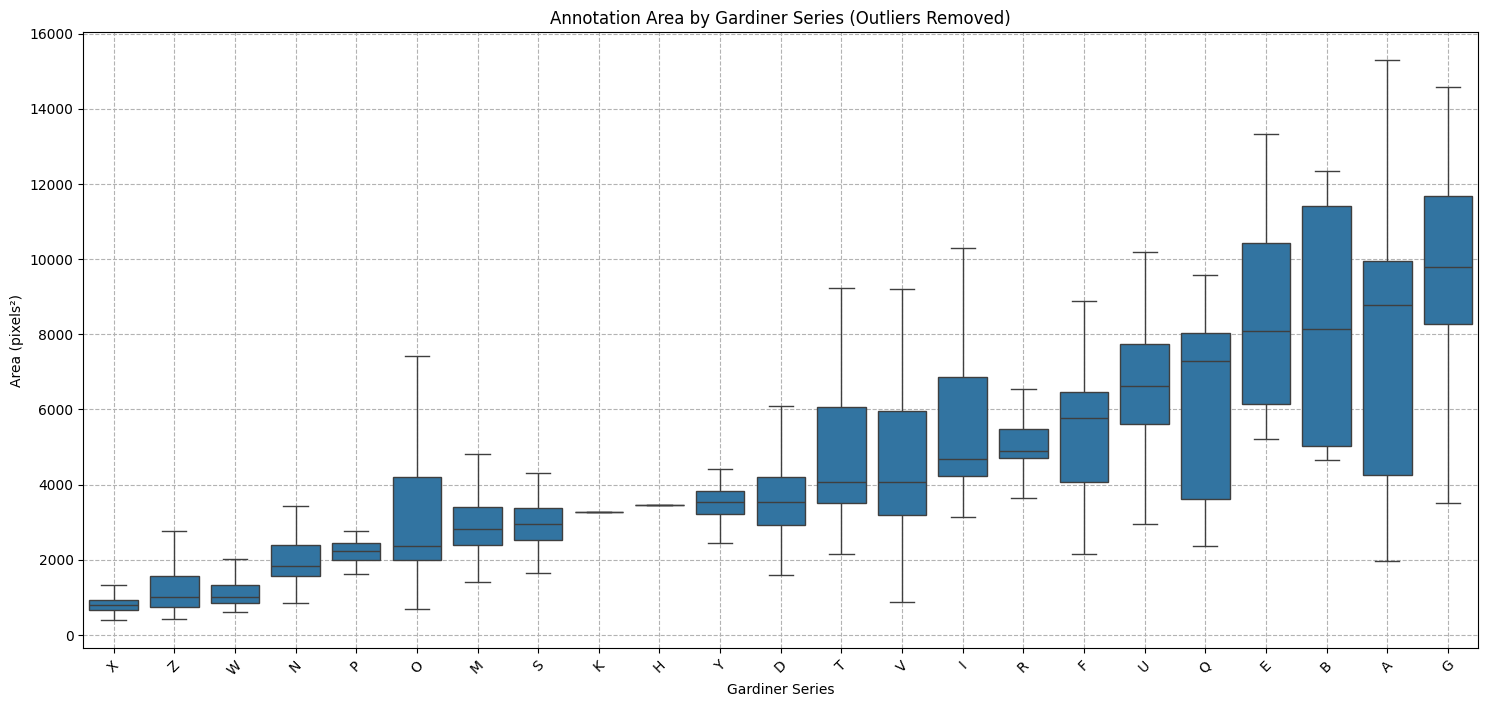

In [15]:
# Box plot of area by Gardiner series
plt.figure(figsize=(18, 8))
sorted_series = annotations_df.groupby('gardiner_series')['area'].median().sort_values().index
sns.boxplot(data=annotations_df, x='gardiner_series', y='area', order=sorted_series, showfliers=False)
plt.title('Annotation Area by Gardiner Series (Outliers Removed)')
plt.xlabel('Gardiner Series')
plt.ylabel('Area (pixels²)')
plt.xticks(rotation=45)
plt.grid(True, which="both", ls="--", c='0.7')
plt.savefig(f'{ANALYSIS_PLOTS_DIR}/area_by_series_boxplot.png')
plt.show()

This plot helps us understand if certain types of hieroglyphs (e.g., humans, birds, tools) are consistently larger or smaller than others.

## Summary and Insights for Modeling

This analysis provides several key takeaways for our model training strategy:

In [17]:
report = {
    "bbox_insights": {
        "area_mean": float(annotations_df['area'].mean()),
        "area_median": float(annotations_df['area'].median()),
        "area_std": float(annotations_df['area'].std()),
        "aspect_ratio_mean": float(annotations_df['aspect_ratio'].mean()),
        "aspect_ratio_median": float(annotations_df['aspect_ratio'].median()),
        "notes": ["Wide variation in both area and aspect ratio, suggesting multi-scale training and flexible anchor generation will be important."]
    },
    "spatial_insights": {
        "distribution_pattern": "Hieroglyphs are arranged in clear vertical columns.",
        "notes": ["The non-uniform distribution means random crops might create samples with no annotations. Spatial augmentation should be done carefully."]
    },
    "class_insights": {
        "total_classes": int(annotations_df['category_name'].nunique()),
        "classes_with_one_sample": int((annotations_df['category_name'].value_counts() == 1).sum()),
        "most_common_class": annotations_df['category_name'].value_counts().idxmax(),
        "notes": ["Extreme class imbalance is a major challenge. Many classes have very few examples. This justifies our stratified split and suggests we might need techniques like class weighting or focal loss during training."]
    }
}

# Save the report
report_file = f'{ANALYSIS_PLOTS_DIR}/eda_summary_report.json'
with open(report_file, 'w') as f:
    json.dump(report, f, indent=4)

print("📋 EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*50)
print("Bounding Box Insights:")
print(f"- Mean Area: {report['bbox_insights']['area_mean']:.2f}, Median Area: {report['bbox_insights']['area_median']:.2f}")
print(f"- Mean Aspect Ratio: {report['bbox_insights']['aspect_ratio_mean']:.2f}, Median: {report['bbox_insights']['aspect_ratio_median']:.2f}")
print(f"- Note: {report['bbox_insights']['notes'][0]}")

print("Spatial Insights:")
print(f"- Pattern: {report['spatial_insights']['distribution_pattern']}")
print(f"- Note: {report['spatial_insights']['notes'][0]}")

print("Class Balance Insights:")
print(f"- Total Classes: {report['class_insights']['total_classes']}")
print(f"- Single-instance classes: {report['class_insights']['classes_with_one_sample']}")
print(f"- Note: {report['class_insights']['notes'][0]}")

print(f"\n✅ Analysis complete. Report and plots saved to {ANALYSIS_PLOTS_DIR}")
print("\n🚀 NEXT STEP: Proceed to 03_model_training.ipynb to train the model.")

📋 EXPLORATORY DATA ANALYSIS SUMMARY
Bounding Box Insights:
- Mean Area: 4382.06, Median Area: 3371.28
- Mean Aspect Ratio: 2.35, Median: 1.78
- Note: Wide variation in both area and aspect ratio, suggesting multi-scale training and flexible anchor generation will be important.
Spatial Insights:
- Pattern: Hieroglyphs are arranged in clear vertical columns.
- Note: The non-uniform distribution means random crops might create samples with no annotations. Spatial augmentation should be done carefully.
Class Balance Insights:
- Total Classes: 177
- Single-instance classes: 82
- Note: Extreme class imbalance is a major challenge. Many classes have very few examples. This justifies our stratified split and suggests we might need techniques like class weighting or focal loss during training.

✅ Analysis complete. Report and plots saved to /content/drive/My Drive/PapyrusNU_Detectron/data/analysis_plots

🚀 NEXT STEP: Proceed to 03_model_training.ipynb to train the model.
